# Moon Cycles: Turning Points (Step 1)

This notebook is the first step for the new target: predict **trend-change points**.

Current step scope:
- Build transparent turning-point labels from price only.
- Visualize dark turning markers and light regime bands between key points.
- Keep baseline config aligned with `moon_cycles_classic_transit_blocks2.ipynb`.


In [1]:
from __future__ import annotations

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path('/home/rut/ostrofun')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from RESEARCH.config import cfg as project_cfg
from RESEARCH2.Moon_cycles.moon_data import load_market_slice
from RESEARCH2.Moon_cycles.turning_points import (
    TurningPointLabelConfig,
    label_turning_points,
    plot_turning_points_chart,
)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)

# Higher-resolution charts for notebook rendering.
PLOT_DPI = 180
plt.rcParams['figure.dpi'] = PLOT_DPI
plt.rcParams['savefig.dpi'] = PLOT_DPI
try:
    from matplotlib_inline.backend_inline import set_matplotlib_formats
    set_matplotlib_formats('retina')
except Exception:
    pass


In [2]:
# Baseline config (kept aligned with classic transit notebook).
START_DATE = '2017-11-01'
END_DATE = None

SPLIT_MODE = 'classic'
TRAIN_RATIO = 0.50
VAL_RATIO = 0.20

ORB_MULT = 0.1
USE_CACHE = True
VERBOSE = True
BIRTH_DT_UTC = str(project_cfg.subject.get('birth_dt_utc', '2009-10-10T18:15:05Z'))

# Price plot scale: 'linear' or 'log'.
PLOT_Y_SCALE = 'log'

# Optional manual plot window.
# Use either explicit dates or last N days.
PLOT_START_DATE = None  # e.g. '2022-01-01'
PLOT_END_DATE = None    # e.g. '2024-12-31'
PLOT_LAST_N_DAYS = None

# Turning-point labeling config (step-1 defaults + past confirmation).
# Last open tail is inferred by start->end move sign, so strong terminal
# drops do not stay green only because the last confirmed turn was UP.
TAIL_DIRECTION_MODE = 'endpoint_sign'  # last_turn | endpoint_sign
TAIL_MIN_MOVE_PCT = 0.0
TURN_CFG = TurningPointLabelConfig(
    horizon_days=10,
    up_move_pct=0.09,
    down_move_pct=0.09,
    cluster_gap_days=2,
    min_turn_gap_days=2,
    past_horizon_days=10,
    past_up_move_pct=0.09,
    past_down_move_pct=0.09,
    tail_direction_mode=TAIL_DIRECTION_MODE,
    tail_min_move_pct=TAIL_MIN_MOVE_PCT,
)

print('Data range:', START_DATE, '->', END_DATE or 'latest')
print('Split mode:', SPLIT_MODE, 'ratios train/val/test=', TRAIN_RATIO, VAL_RATIO, 1.0 - TRAIN_RATIO - VAL_RATIO)
print('Birth datetime (for later astro merge):', BIRTH_DT_UTC)
print('Y scale:', PLOT_Y_SCALE)
print('Plot window manual:', PLOT_START_DATE, '->', PLOT_END_DATE, '| last_n_days=', PLOT_LAST_N_DAYS)
print('Turning config:', TURN_CFG)
print('Tail direction mode:', TAIL_DIRECTION_MODE, '| tail min move pct:', TAIL_MIN_MOVE_PCT)


Data range: 2017-11-01 -> latest
Split mode: classic ratios train/val/test= 0.5 0.2 0.3
Birth datetime (for later astro merge): 2009-10-10T18:15:05Z
Y scale: log
Plot window manual: None -> None | last_n_days= None
Turning config: TurningPointLabelConfig(horizon_days=10, up_move_pct=0.09, down_move_pct=0.09, cluster_gap_days=2, min_turn_gap_days=2, past_horizon_days=10, past_up_move_pct=0.09, past_down_move_pct=0.09)


In [3]:
# Load market series.
df_market = load_market_slice(
    start_date=START_DATE,
    end_date=END_DATE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
)

print('Market rows:', len(df_market))
print('Market date range:', df_market['date'].min(), '->', df_market['date'].max())
display(df_market.tail(5))


📂 Loading from cache: research2_moon__market__2017-11-01__8953c00f.parquet
Market rows: 3017
Market date range: 2017-11-01 00:00:00 -> 2026-02-03 00:00:00


,date,close
3012,2026-01-30,84211.4
3013,2026-01-31,78706.8
3014,2026-02-01,76931.5
3015,2026-02-02,78692.5
3016,2026-02-03,75732.4


In [ ]:
# Interactive tuner: adjust turning-point parameters and inspect missed reversals.
try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception:
    widgets = None


def _build_reference_extrema(df_src: pd.DataFrame, half_window: int) -> pd.DataFrame:
    """Build local extrema reference points for coverage diagnostics."""
    half_window = int(max(1, half_window))
    df = df_src[['date', 'close']].copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    prices = df['close'].to_numpy(dtype=float)
    dates = pd.to_datetime(df['date'])
    rows = []

    for i in range(half_window, len(df) - half_window):
        center = prices[i]
        left = prices[i - half_window:i]
        right = prices[i + 1:i + 1 + half_window]

        if center > float(np.max(left)) and center >= float(np.max(right)):
            rows.append({'date': dates.iloc[i], 'close': center, 'direction': -1})
        elif center < float(np.min(left)) and center <= float(np.min(right)):
            rows.append({'date': dates.iloc[i], 'close': center, 'direction': 1})

    return pd.DataFrame(rows, columns=['date', 'close', 'direction'])


def _coverage_stats(df_tp: pd.DataFrame, df_ref: pd.DataFrame, tolerance_days: int) -> tuple[float, float, float]:
    """Coverage of reference extrema by nearby turning points of same direction."""
    tol = int(max(0, tolerance_days))

    def _by_direction(direction: int) -> float:
        ref_dates = pd.to_datetime(df_ref.loc[df_ref['direction'] == direction, 'date']).reset_index(drop=True)
        tp_dates = pd.to_datetime(df_tp.loc[df_tp['turning_direction'] == direction, 'date']).reset_index(drop=True)

        if len(ref_dates) == 0:
            return float('nan')
        if len(tp_dates) == 0:
            return 0.0

        matched = 0
        for ref_dt in ref_dates:
            delta_days = (tp_dates - ref_dt).abs().dt.days
            if bool((delta_days <= tol).any()):
                matched += 1
        return float(matched) / float(len(ref_dates))

    cov_up = _by_direction(1)
    cov_down = _by_direction(-1)

    ref_all = pd.to_datetime(df_ref['date']).reset_index(drop=True)
    tp_all = pd.to_datetime(df_tp['date']).reset_index(drop=True)

    if len(ref_all) == 0:
        cov_total = float('nan')
    elif len(tp_all) == 0:
        cov_total = 0.0
    else:
        matched = 0
        for ref_dt in ref_all:
            delta_days = (tp_all - ref_dt).abs().dt.days
            if bool((delta_days <= tol).any()):
                matched += 1
        cov_total = float(matched) / float(len(ref_all))

    return cov_total, cov_up, cov_down


def _select_plot_window(
    df_src: pd.DataFrame,
    plot_window_mode: str,
    plot_last_n_days: int,
    plot_range_pct: tuple[int, int],
) -> pd.DataFrame:
    mode = str(plot_window_mode)
    if mode == 'last_n_days' and int(plot_last_n_days) > 0:
        return df_src.tail(int(plot_last_n_days)).copy()

    if mode == 'range_pct':
        n = len(df_src)
        if n == 0:
            return df_src.copy()
        p0 = int(plot_range_pct[0])
        p1 = int(plot_range_pct[1])
        lo, hi = (p0, p1) if p0 <= p1 else (p1, p0)
        lo = max(0, min(99, lo))
        hi = max(lo + 1, min(100, hi))

        i0 = int(np.floor((lo / 100.0) * max(0, n - 1)))
        i1 = int(np.ceil((hi / 100.0) * max(0, n - 1)))
        i1 = max(i0 + 1, i1)
        return df_src.iloc[i0:i1 + 1].copy()

    return df_src.copy()


def _render_turning_preview(
    horizon_days: int,
    up_move_pct: float,
    down_move_pct: float,
    cluster_gap_days: int,
    min_turn_gap_days: int,
    past_horizon_days: int,
    past_up_move_pct: float,
    past_down_move_pct: float,
    plot_window_mode: str,
    plot_last_n_days: int,
    plot_range_pct: tuple[int, int],
    extrema_window_days: int,
    match_tolerance_days: int,
    y_scale: str,
) -> None:
    global TURN_CFG, PLOT_Y_SCALE, PLOT_START_DATE, PLOT_END_DATE, PLOT_LAST_N_DAYS

    PLOT_Y_SCALE = str(y_scale)
    TURN_CFG = TurningPointLabelConfig(
        horizon_days=int(horizon_days),
        up_move_pct=float(up_move_pct),
        down_move_pct=float(down_move_pct),
        cluster_gap_days=int(cluster_gap_days),
        min_turn_gap_days=int(min_turn_gap_days),
        past_horizon_days=int(past_horizon_days),
        past_up_move_pct=float(past_up_move_pct),
        past_down_move_pct=float(past_down_move_pct),
        tail_direction_mode=str(TAIL_DIRECTION_MODE),
        tail_min_move_pct=float(TAIL_MIN_MOVE_PCT),
    )

    df_candidates_i, df_turning_points_i, df_regimes_i = label_turning_points(df_market, TURN_CFG)

    df_plot_i = _select_plot_window(
        df_src=df_market,
        plot_window_mode=str(plot_window_mode),
        plot_last_n_days=int(plot_last_n_days),
        plot_range_pct=plot_range_pct,
    )
    if df_plot_i.empty:
        print('Selected window is empty. Expand range.')
        return

    plot_start = pd.to_datetime(df_plot_i['date'].min())
    plot_end = pd.to_datetime(df_plot_i['date'].max())

    if str(plot_window_mode) == 'last_n_days':
        PLOT_START_DATE = None
        PLOT_END_DATE = None
        PLOT_LAST_N_DAYS = int(plot_last_n_days)
    elif str(plot_window_mode) == 'range_pct':
        PLOT_START_DATE = str(plot_start.date())
        PLOT_END_DATE = str(plot_end.date())
        PLOT_LAST_N_DAYS = None
    else:
        PLOT_START_DATE = None
        PLOT_END_DATE = None
        PLOT_LAST_N_DAYS = None

    df_tp_plot_i = df_turning_points_i[(df_turning_points_i['date'] >= plot_start) & (df_turning_points_i['date'] <= plot_end)].copy()
    df_regimes_plot_i = df_regimes_i[(df_regimes_i['end_date'] >= plot_start) & (df_regimes_i['start_date'] <= plot_end)].copy()

    df_ref_i = _build_reference_extrema(df_plot_i, half_window=int(extrema_window_days))
    cov_total, cov_up, cov_down = _coverage_stats(
        df_tp=df_tp_plot_i,
        df_ref=df_ref_i,
        tolerance_days=int(match_tolerance_days),
    )

    n_up = int((df_tp_plot_i['turning_direction'] == 1).sum()) if not df_tp_plot_i.empty else 0
    n_down = int((df_tp_plot_i['turning_direction'] == -1).sum()) if not df_tp_plot_i.empty else 0

    print(
        f'Window: {plot_start.date()} -> {plot_end.date()} | mode={plot_window_mode} | '
        f'Active TURN_CFG: {TURN_CFG} | y_scale={PLOT_Y_SCALE} | points={len(df_tp_plot_i)} (UP={n_up}, DOWN={n_down}) | '
        f'ref_extrema={len(df_ref_i)} | coverage<=±{int(match_tolerance_days)}d: '
        f'total={cov_total:.1%} up={cov_up:.1%} down={cov_down:.1%}'
    )

    title = (
        f'Interactive turning points | {plot_start.date()}..{plot_end.date()} | '
        f'h={TURN_CFG.horizon_days}d | up={TURN_CFG.up_move_pct * 100:.1f}% | '
        f'down={TURN_CFG.down_move_pct * 100:.1f}% | past_h={TURN_CFG.past_horizon_days}d | '
        f'points={len(df_tp_plot_i)} | y={PLOT_Y_SCALE}'
    )

    fig, ax = plot_turning_points_chart(
        df_market=df_plot_i,
        df_turning_points=df_tp_plot_i,
        df_regimes=df_regimes_plot_i,
        title=title,
        y_scale=PLOT_Y_SCALE,
    )

    if not df_ref_i.empty:
        ref_up = df_ref_i[df_ref_i['direction'] == 1]
        ref_down = df_ref_i[df_ref_i['direction'] == -1]

        if not ref_up.empty:
            ax.scatter(ref_up['date'], ref_up['close'], marker='o', s=42, facecolors='none', edgecolors='#1D4ED8', linewidths=1.0, alpha=0.95, label='Reference trough (UP turn)', zorder=6)
        if not ref_down.empty:
            ax.scatter(ref_down['date'], ref_down['close'], marker='o', s=42, facecolors='none', edgecolors='#B45309', linewidths=1.0, alpha=0.95, label='Reference peak (DOWN turn)', zorder=6)

    ax.legend(loc='best')
    plt.show()


if widgets is None:
    print('ipywidgets is not installed; run `pip install ipywidgets` for live controls.')
    _render_turning_preview(
        horizon_days=int(TURN_CFG.horizon_days),
        up_move_pct=float(TURN_CFG.up_move_pct),
        down_move_pct=float(TURN_CFG.down_move_pct),
        cluster_gap_days=int(TURN_CFG.cluster_gap_days),
        min_turn_gap_days=int(TURN_CFG.min_turn_gap_days),
        past_horizon_days=int(TURN_CFG.past_horizon_days),
        past_up_move_pct=float(TURN_CFG.past_up_move_pct if TURN_CFG.past_up_move_pct is not None else TURN_CFG.up_move_pct),
        past_down_move_pct=float(TURN_CFG.past_down_move_pct if TURN_CFG.past_down_move_pct is not None else TURN_CFG.down_move_pct),
        plot_window_mode='full',
        plot_last_n_days=0,
        plot_range_pct=(70, 100),
        extrema_window_days=7,
        match_tolerance_days=4,
        y_scale=str(PLOT_Y_SCALE),
    )
else:
    max_plot_days = int(max(120, len(df_market)))
    controls = {
        'horizon_days': widgets.IntSlider(value=int(TURN_CFG.horizon_days), min=2, max=45, step=1, description='horizon'),
        'up_move_pct': widgets.FloatSlider(value=float(TURN_CFG.up_move_pct), min=0.01, max=0.25, step=0.0025, readout_format='.3f', description='up_pct'),
        'down_move_pct': widgets.FloatSlider(value=float(TURN_CFG.down_move_pct), min=0.01, max=0.25, step=0.0025, readout_format='.3f', description='down_pct'),
        'cluster_gap_days': widgets.IntSlider(value=int(TURN_CFG.cluster_gap_days), min=0, max=15, step=1, description='cluster_gap'),
        'min_turn_gap_days': widgets.IntSlider(value=int(TURN_CFG.min_turn_gap_days), min=1, max=20, step=1, description='min_turn_gap'),
        'past_horizon_days': widgets.IntSlider(value=int(TURN_CFG.past_horizon_days), min=0, max=45, step=1, description='past_horizon'),
        'past_up_move_pct': widgets.FloatSlider(value=float(TURN_CFG.past_up_move_pct if TURN_CFG.past_up_move_pct is not None else TURN_CFG.up_move_pct), min=0.01, max=0.25, step=0.0025, readout_format='.3f', description='past_up'),
        'past_down_move_pct': widgets.FloatSlider(value=float(TURN_CFG.past_down_move_pct if TURN_CFG.past_down_move_pct is not None else TURN_CFG.down_move_pct), min=0.01, max=0.25, step=0.0025, readout_format='.3f', description='past_down'),
        'plot_window_mode': widgets.Dropdown(options=['full', 'last_n_days', 'range_pct'], value='range_pct', description='window_mode'),
        'plot_last_n_days': widgets.IntSlider(value=365, min=0, max=max_plot_days, step=30, description='last_n'),
        'plot_range_pct': widgets.IntRangeSlider(value=(70, 100), min=0, max=100, step=1, description='range_%'),
        'extrema_window_days': widgets.IntSlider(value=7, min=2, max=30, step=1, description='ext_window'),
        'match_tolerance_days': widgets.IntSlider(value=4, min=0, max=20, step=1, description='match_tol'),
        'y_scale': widgets.Dropdown(options=['linear', 'log'], value=str(PLOT_Y_SCALE), description='y_scale'),
    }

    display(widgets.HTML('<b>Interactive turning-point tuner:</b> choose params + window mode (full / last_n / range_%).'))
    display(widgets.VBox([controls[k] for k in controls]))
    display(widgets.interactive_output(_render_turning_preview, controls))


HTML(value='<b>Interactive turning-point tuner:</b> choose params + window mode (full / last_n / range_%).')

Output()

In [8]:
# Build turning-point labels and regimes.
df_candidates, df_turning_points, df_regimes = label_turning_points(df_market, TURN_CFG)

n_up = int((df_turning_points['turning_direction'] == 1).sum()) if not df_turning_points.empty else 0
n_down = int((df_turning_points['turning_direction'] == -1).sum()) if not df_turning_points.empty else 0

print('Candidates (raw non-zero):', int((df_candidates['candidate_direction'] != 0).sum()))
print('Turning points (compressed):', len(df_turning_points), '| UP:', n_up, '| DOWN:', n_down)

if not df_regimes.empty:
    print('Regime intervals:', len(df_regimes), '| avg duration days:', round(float(df_regimes['duration_days'].mean()), 2))

display(df_turning_points.head(30))


Candidates (raw non-zero): 944
Turning points (compressed): 97 | UP: 51 | DOWN: 46
Regime intervals: 97 | avg duration days: 30.98


,date,close,turning_direction,candidate_score,max_future_return,min_future_return,up_hit_days,down_hit_days,past_max_return,past_min_return,past_up_confirm,past_down_confirm,run_id
0,2017-11-12,5878.10,1,0.402613,0.402613,0.109627,1.0,NaN,-0.072840,-0.210400,0,1,1
1,2017-12-09,14843.40,1,0.303307,0.303307,0.014565,2.0,NaN,0.592913,-0.119102,1,1,3
2,2017-12-30,12531.50,1,0.370331,0.370331,0.072888,1.0,NaN,-0.082949,-0.342720,0,1,7
3,2018-01-12,13886.70,-1,0.217611,0.029201,-0.217611,NaN,4.0,0.108143,-0.191331,1,1,10
4,2018-02-07,7594.70,1,0.458056,0.458056,0.064150,1.0,NaN,0.094574,-0.356114,1,1,14
5,2018-03-04,11416.50,-1,0.280813,-0.007524,-0.280813,NaN,2.0,0.191055,0.001245,1,0,23
6,2018-03-23,8916.80,-1,0.234568,-0.041427,-0.234568,NaN,1.0,0.132306,-0.064305,1,0,25
7,2018-04-10,6854.80,1,0.293546,0.293546,0.015653,2.0,NaN,0.034796,-0.138292,0,1,26
8,2018-05-05,9853.50,-1,0.146669,-0.020003,-0.146669,NaN,2.0,0.118864,0.010646,1,0,29
9,2018-06-28,5883.50,1,0.149911,0.149911,0.056055,1.0,NaN,-0.028436,-0.130354,0,1,32


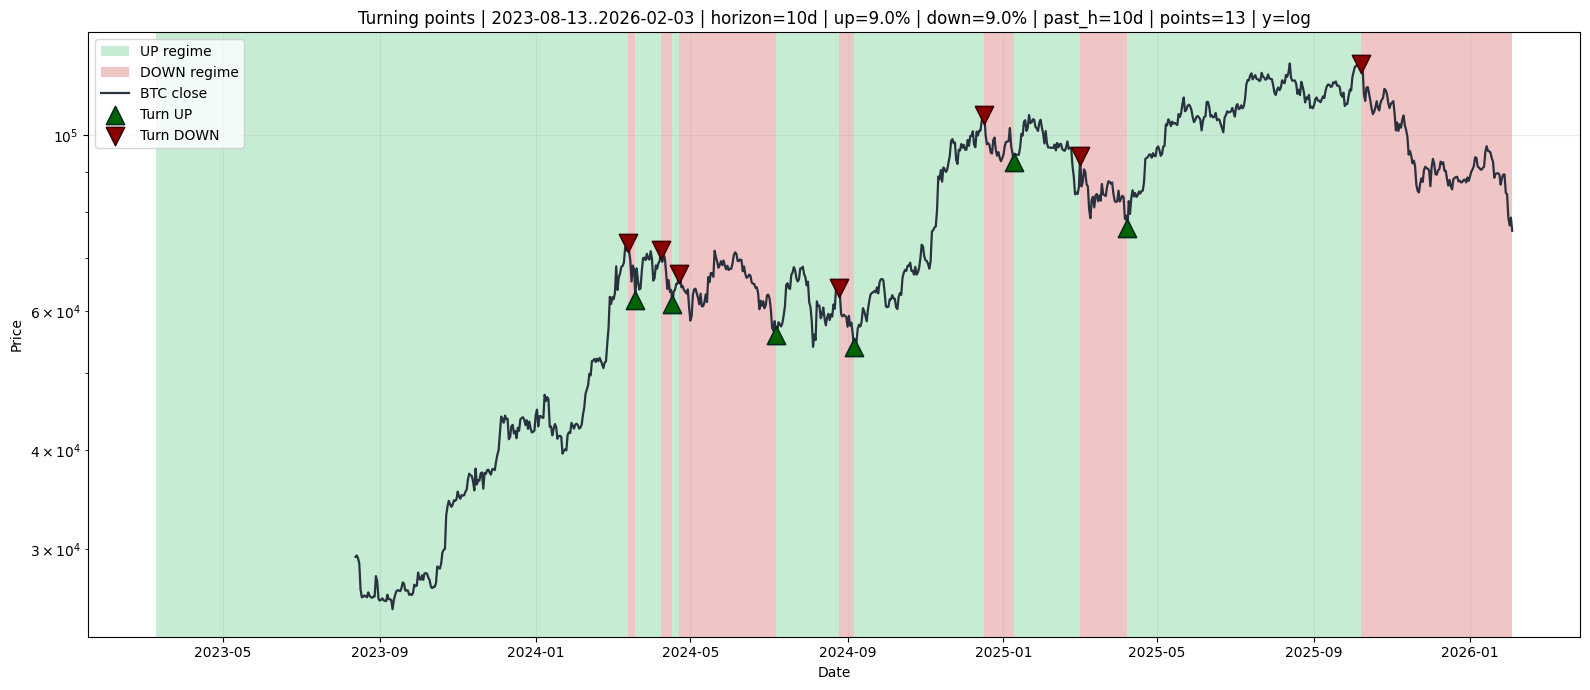

In [6]:
# Plot price + turning points + shaded regimes.
df_plot = df_market.copy()

if PLOT_START_DATE is not None or PLOT_END_DATE is not None:
    start_dt = pd.to_datetime(PLOT_START_DATE) if PLOT_START_DATE is not None else pd.to_datetime(df_plot['date'].min())
    end_dt = pd.to_datetime(PLOT_END_DATE) if PLOT_END_DATE is not None else pd.to_datetime(df_plot['date'].max())
    df_plot = df_plot[(pd.to_datetime(df_plot['date']) >= start_dt) & (pd.to_datetime(df_plot['date']) <= end_dt)].copy()
elif PLOT_LAST_N_DAYS is not None:
    df_plot = df_plot.tail(int(PLOT_LAST_N_DAYS)).copy()

if df_plot.empty:
    raise ValueError('Selected plot window is empty. Check PLOT_START_DATE/PLOT_END_DATE/PLOT_LAST_N_DAYS.')

plot_start = pd.to_datetime(df_plot['date'].min())
plot_end = pd.to_datetime(df_plot['date'].max())

df_tp_plot = df_turning_points[(df_turning_points['date'] >= plot_start) & (df_turning_points['date'] <= plot_end)].copy()
df_regimes_plot = df_regimes[(df_regimes['end_date'] >= plot_start) & (df_regimes['start_date'] <= plot_end)].copy()

title = (
    f'Turning points | {plot_start.date()}..{plot_end.date()} | '
    f'horizon={TURN_CFG.horizon_days}d | '
    f'up={TURN_CFG.up_move_pct*100:.1f}% | down={TURN_CFG.down_move_pct*100:.1f}% | '
    f'past_h={TURN_CFG.past_horizon_days}d | points={len(df_tp_plot)} | y={PLOT_Y_SCALE}'
)

fig, ax = plot_turning_points_chart(
    df_market=df_plot,
    df_turning_points=df_tp_plot,
    df_regimes=df_regimes_plot,
    title=title,
    y_scale=PLOT_Y_SCALE,
)
plt.show()


In [7]:
# Diagnostics table: inspect where/why candidates are generated.
diag_cols = [
    'date', 'close',
    'max_future_return', 'min_future_return',
    'up_hit_days', 'down_hit_days',
    'past_max_return', 'past_min_return',
    'past_up_confirm', 'past_down_confirm',
    'candidate_direction', 'candidate_score', 'turning_point',
]

df_diag = df_candidates[diag_cols].copy()
df_diag['max_future_return_pct'] = 100.0 * df_diag['max_future_return']
df_diag['min_future_return_pct'] = 100.0 * df_diag['min_future_return']
df_diag['past_max_return_pct'] = 100.0 * df_diag['past_max_return']
df_diag['past_min_return_pct'] = 100.0 * df_diag['past_min_return']

display(df_diag.tail(60))


,date,close,max_future_return,min_future_return,up_hit_days,down_hit_days,past_max_return,past_min_return,past_up_confirm,past_down_confirm,candidate_direction,candidate_score,turning_point,max_future_return_pct,min_future_return_pct,past_max_return_pct,past_min_return_pct
2957,2025-12-06,89197.1,0.038581,-0.031472,NaN,NaN,0.034270,-0.044761,0,0,0,0.0,0,3.858085,-3.147188,3.427000,-4.476063
2958,2025-12-07,90345.4,0.025380,-0.045866,NaN,NaN,0.047585,-0.032463,0,0,0,0.0,0,2.538037,-4.586620,4.758492,-3.246313
2959,2025-12-08,90610.8,0.022377,-0.056738,NaN,NaN,0.050662,-0.029621,0,0,0,0.0,0,2.237702,-5.673827,5.066233,-2.962088
2960,2025-12-09,92638.4,-0.001737,-0.077384,NaN,NaN,0.074173,-0.007907,0,0,0,0.0,0,-0.173686,-7.738368,7.417302,-0.790668
2961,2025-12-10,91977.5,0.005436,-0.070754,NaN,NaN,0.066510,-0.014984,0,0,0,0.0,0,0.543611,-7.075426,6.650967,-1.498447
2962,2025-12-11,92477.5,-0.024308,-0.075778,NaN,NaN,0.072307,-0.009630,0,0,0,0.0,0,-2.430753,-7.577843,7.230733,-0.962981
2963,2025-12-12,90229.6,-0.000424,-0.052753,NaN,NaN,0.011575,-0.033703,0,0,0,0.0,0,-0.042447,-5.275320,1.157549,-3.370327
2964,2025-12-13,90191.3,-0.017407,-0.052351,NaN,NaN,0.011146,-0.034113,0,0,0,0.0,0,-1.740744,-5.235095,1.114610,-3.411344
2965,2025-12-14,88118.8,0.005703,-0.030063,NaN,NaN,-0.012089,-0.048788,0,0,0,0.0,0,0.570253,-3.006282,-1.208896,-4.878754
2966,2025-12-15,86389.9,0.025829,-0.010652,NaN,NaN,-0.019620,-0.067450,0,0,0,0.0,0,2.582941,-1.065171,-1.962010,-6.745043
